In [ ]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def compute_phase_gate_from_V(V):
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    return P

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def scheme_permutations(scheme):
    pair_lists = [pairs for (_, pairs) in scheme]
    perms_per_col = [list(itertools.permutations(pl)) if len(pl) > 1 else [pl] for pl in pair_lists]
    idx_lists = [list(range(len(pl))) for pl in perms_per_col]
    for combo in itertools.product(*idx_lists):
        new_scheme = []
        for (col, _), idx, perms in zip(scheme, combo, perms_per_col):
            new_scheme.append((col, list(perms[idx])))
        yield new_scheme

def decompose_and_reconstruct(U, scheme, tol=1e-10):
    rotation_mats, V = taqr_eliminate(U, scheme, tol)
    P = compute_phase_gate_from_V(V)
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    diff = norm(U - U_rec)
    return rotation_mats, P, U_rec, diff

def print_sequence(rotation_mats, P):
    for k, G in enumerate(rotation_mats):
        (i, j), frac, phi = inverse_single_pulse(G)
        print(f"{k:2d}: coupling ({i},{j}), theta={frac:.6f}, phi={phi/np.pi:.6f}")
    phases = np.angle(np.diag(P))
    print("Diagonal phases (per level, /pi):", phases / np.pi)

# def demo():
#     dim = 4
#     adj = build_star_adj(dim, center=0)
#     scheme = build_taqr_scheme(adj)
#     print("Base TAQR scheme:")
#     print(scheme)
#     U = haar_su(dim, rng=2)
#     QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
#     Hadamard = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
#     # U = np.kron(Hadamard, Hadamard)
#     # U = np.kron(U, Hadamard) 
#     U = QFT
#     print("Original U:")
#     print(np.round(U, 3))
#     base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
#     print("\nBase scheme reconstruction:")
#     print("Reconstructed U:")
#     print(np.round(base_Urec, 3))
#     print("||U - U_rec|| =", base_diff)
#     print("Number of rotations:", len(base_rots))
#     print("Base sequence:")
#     print_sequence(base_rots, base_P)
#     print("\nIterating over permutations of couplings inside each column...")
#     valid_id = 0
#     for idx, sch in enumerate(scheme_permutations(scheme)):
#         rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
#         if diff < 1e-8:
#             print("\nValid permutation id:", valid_id)
#             valid_id += 1
#             print("Scheme:", sch)
#             print("||U - U_rec|| =", diff)
#             print("Number of rotations:", len(rots))
#             print("Sequence:")
#             print_sequence(rots, P)

def demo_perm(dim = 4, rng = 2):
    adj = build_star_adj(dim, center=0)
    scheme = build_taqr_scheme(adj)
    # print("Base TAQR scheme:")
    # print(scheme)
    U = haar_su(dim, rng)
    # QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
    # Hadamard = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    # U = np.kron(Hadamard, Hadamard)
    # U = np.kron(U, Hadamard) 
    # U = QFT
    # print("Original U:")
    # print(np.round(U, 3))
    base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
    print("\nBase scheme reconstruction:")
    print("Reconstructed U:")
    print(np.round(base_Urec, 3))
    print("||U - U_rec|| =", base_diff)
    print("Number of rotations:", len(base_rots))
    print("Base sequence:")
    print_sequence(base_rots, base_P)

    print("\nSearching permutations for best scheme...")
    best_scheme = None
    best_rots = None
    best_P = None
    best_diff = None
    best_num = None
    best_theta_sum = None
    for sch in scheme_permutations(scheme):
        print(sch)
        rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
        if diff >= 1e-8:
            continue
        num = len(rots)
        theta_sum = 0.0
        for G in rots:
            # print(G)
            (_, _), frac, _ = inverse_single_pulse(G)
            theta_sum += frac
        print(theta_sum)
        if best_scheme is None:
            best_scheme = sch
            best_rots = rots
            best_P = P
            best_diff = diff
            best_num = num
            best_theta_sum = theta_sum
        else:
            if num < best_num or (num == best_num and theta_sum < best_theta_sum):
                best_scheme = sch
                best_rots = rots
                best_P = P
                best_diff = diff
                best_num = num
                best_theta_sum = theta_sum

    if best_scheme is not None:
        print("\nBest scheme:")
        print("Scheme:", best_scheme)
        print("||U - U_rec|| =", best_diff)
        print("Number of rotations:", best_num)
        print("Sum theta/pi:", best_theta_sum)
        print("Best sequence:")
        print_sequence(best_rots, best_P)
    if best_scheme is None:
        print("No valid permutation found.")
    return best_theta_sum


print(demo_perm(4,1))


Base scheme reconstruction:
Reconstructed U:
[[ 0.103+0.053j  0.809-0.096j  0.147-0.212j  0.296+0.412j]
 [ 0.281+0.109j -0.085-0.348j -0.384+0.409j -0.339+0.592j]
 [ 0.431-0.803j  0.216+0.02j   0.024+0.062j -0.278-0.202j]
 [-0.255-0.02j   0.356+0.187j -0.44 +0.648j  0.271-0.293j]]
||U - U_rec|| = 1.0100620163399279e-15
Number of rotations: 6
Base sequence:
 0: coupling (0,1), theta=0.593130, phi=1.636077
 1: coupling (0,2), theta=0.244497, phi=0.800131
 2: coupling (0,3), theta=0.738376, phi=1.262195
 3: coupling (0,1), theta=0.325737, phi=0.530736
 4: coupling (0,2), theta=0.873076, phi=0.770314
 5: coupling (0,1), theta=0.172502, phi=0.609823
Diagonal phases (per level, /pi): [-4.03091132e-17  1.82219279e-17 -0.00000000e+00 -0.00000000e+00]

Searching permutations for best scheme...
[(3, [(1, 0), (2, 0), (0, 3)]), (2, [(1, 0), (0, 2)]), (1, [(0, 1)]), (0, [])]
[[ 0.34835862-0.48418533j -0.39854598-0.69668641j  0.        +0.j
   0.        +0.j        ]
 [ 0.39854598-0.69668641j  0.34

In [46]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools
import numpy as np
from numpy.linalg import norm
from math import acos, pi
def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def compute_phase_gate_from_V(V):
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    return P

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def scheme_permutations(scheme):
    pair_lists = [pairs for (_, pairs) in scheme]
    perms_per_col = [list(itertools.permutations(pl)) if len(pl) > 1 else [pl] for pl in pair_lists]
    idx_lists = [list(range(len(pl))) for pl in perms_per_col]
    for combo in itertools.product(*idx_lists):
        new_scheme = []
        for (col, _), idx, perms in zip(scheme, combo, perms_per_col):
            new_scheme.append((col, list(perms[idx])))
        yield new_scheme

def decompose_and_reconstruct(U, scheme, tol=1e-10):
    rotation_mats, V = taqr_eliminate(U, scheme, tol)
    P = compute_phase_gate_from_V(V)
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    diff = norm(U - U_rec)
    return rotation_mats, P, U_rec, diff

def print_sequence(rotation_mats, P):
    coupling = []
    theta = []
    phases = []
    for k, G in enumerate(rotation_mats):
        (i, j), frac, phi = inverse_single_pulse(G)
        coupling.append((i, j))
        theta.append(frac)
        phases.append(phi)
        # print(f"{k:2d}: coupling ({i},{j}), theta={frac:.6f}, phi={phi/np.pi:.6f}")
    phases = np.angle(np.diag(P))
    # print("Diagonal phases (per level, /pi):", phases / np.pi)
    return coupling, theta, phases

def demo_perm(dim = 4, rng = 2, U = None):
    adj = build_star_adj(dim, center=0)
    scheme = build_taqr_scheme(adj)
    # print("Base TAQR scheme:")
    # print(scheme)
    if U is None:
        U = haar_su(dim, rng)
        print(np.round(U,3))
    # QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
    # Hadamard = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    # U = np.kron(Hadamard, Hadamard)
    # U = np.kron(U, Hadamard) 
    # U = QFT
    # print("Original U:")
    # print(np.round(U, 3))
    base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
    # print("\nBase scheme reconstruction:")
    # print("Reconstructed U:")
    # print(np.round(base_Urec, 3))
    # print("||U - U_rec|| =", base_diff)
    # print("Number of rotations:", len(base_rots))
    # print("Base sequence:")
    # print_sequence(base_rots, base_P)

    # print("\nSearching permutations for best scheme...")
    best_scheme = None
    best_rots = None
    best_P = None
    best_diff = None
    best_num = None
    best_theta_sum = None
    # for sch in scheme_permutations(scheme):
    for sch in [scheme]:
        # print(sch)
        rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
        if diff >= 1e-8:
            continue
        num = len(rots)
        theta_sum = 0.0
        for G in rots:
            print(np.round(G,4))
            (_, _), frac, _ = inverse_single_pulse(G)
            theta_sum += frac
        # print(theta_sum)
        if best_scheme is None:
            best_scheme = sch
            best_rots = rots
            best_P = P
            best_diff = diff
            best_num = num
            best_theta_sum = theta_sum
        else:
            if num < best_num or (num == best_num and theta_sum < best_theta_sum):
                best_scheme = sch
                best_rots = rots
                best_P = P
                best_diff = diff
                best_num = num
                best_theta_sum = theta_sum

    if best_scheme is not None:
        # print("\nBest scheme:")
        # print("Scheme:", best_scheme)
        # print("||U - U_rec|| =", best_diff)
        # print("Number of rotations:", best_num)
        # print("Sum theta/pi:", best_theta_sum)
        # print("Best sequence:")
        coupling, theta, phase = print_sequence(best_rots, best_P)
        # print("Couplings:", coupling)
        # print("Thetas (in units of pi):", theta)
        # print("Phases (radians):", phase)
    # if best_scheme is None:
    #     print("No valid permutation found.")
    return coupling, theta, phase

coupling, theta, phase = demo_perm(4,4)
print("couplings=", coupling)
print("fractions =", theta)
print("phases =", np.round(phase,9))

[[-0.452-0.344j -0.177+0.239j  0.214-0.622j  0.377-0.121j]
 [-0.485+0.104j -0.451-0.063j -0.326+0.261j  0.148+0.592j]
 [-0.142+0.597j -0.31 -0.218j  0.496-0.289j -0.387+0.016j]
 [ 0.195+0.131j -0.141-0.735j -0.192-0.163j  0.524-0.214j]]
[[ 0.5186+0.1666j  0.2039-0.8134j  0.    +0.j      0.    +0.j    ]
 [-0.2039-0.8134j  0.5186-0.1666j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
[[ 0.8829-0.j      0.    +0.j     -0.4691-0.0198j  0.    +0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.4691-0.0198j  0.    +0.j      0.8829+0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
[[ 0.5244-0.2142j  0.    +0.j      0.    +0.j     -0.8241-0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.8241-0.j      0.   

21
[[-0.7071-0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
   0.7071-0.j  0.    +0.j]
 [ 0.    +0.j  1.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
   0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  1.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
   0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  1.    +0.j  0.    +0.j  0.    +0.j
   0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  1.    +0.j  0.    +0.j
   0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  1.    +0.j
   0.    +0.j  0.    +0.j]
 [-0.7071-0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
  -0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
   0.    +0.j  1.    +0.j]]
[[ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-1.-0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+

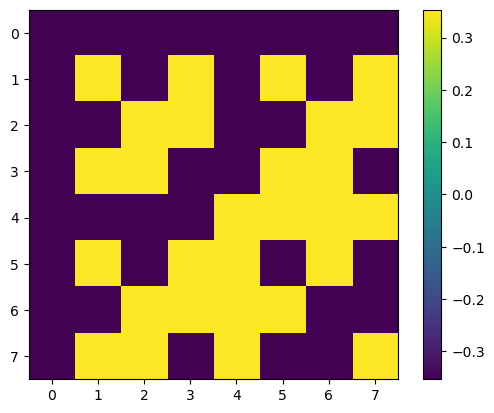

In [47]:
import numpy as np
import math  # For np.hypot
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # In the original scheme the phase was given by fix flag * π.
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        print(np.round(U_pulse,4))
        U_seq = U_pulse @ U_seq
    return U_seq

def unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, f_fit, phi_fit) in zip(couplings, rabi_freqs, fractions_fit, phases_fit):
        i, j = levels
        H_op = coupling_operator_with_phase(i, j, dim, phi_fit)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(f_fit, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        print(np.round(U_pulse))
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

dim = 8

couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]


print(len(couplings))
fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)

A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def compute_phase_gate_from_V(V):
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    return P

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def scheme_permutations(scheme):
    pair_lists = [pairs for (_, pairs) in scheme]
    perms_per_col = [list(itertools.permutations(pl)) if len(pl) > 1 else [pl] for pl in pair_lists]
    idx_lists = [list(range(len(pl))) for pl in perms_per_col]
    for combo in itertools.product(*idx_lists):
        new_scheme = []
        for (col, _), idx, perms in zip(scheme, combo, perms_per_col):
            new_scheme.append((col, list(perms[idx])))
        yield new_scheme

def decompose_and_reconstruct(U, scheme, tol=1e-10):
    rotation_mats, V = taqr_eliminate(U, scheme, tol)
    P = compute_phase_gate_from_V(V)
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    diff = norm(U - U_rec)
    return rotation_mats, P, U_rec, diff

# def extract_pulse_params(rotation_mats, P):
#     couplings = []
#     fractions = []
#     pulse_phases = []
#     for G in rotation_mats:
#         (i, j), frac, phi = inverse_single_pulse(G)
#         couplings.append((i, j))
#         fractions.append(frac)
#         pulse_phases.append(phi)  # shift for your Hamiltonian
#     global_phases = np.angle(np.diag(P))        # one phase per level (virtual Z)
#     return couplings, fractions, pulse_phases, global_phases

# def demo_perm(dim=4, rng=2, U=None):
#     adj = build_star_adj(dim, center=0)
#     scheme = build_taqr_scheme(adj)
#     if U is None:
#         U = haar_su(dim, rng)
#     print(  np.round(U,3))
#     base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
#     best_scheme = None
#     best_rots = None
#     best_P = None
#     best_diff = None
#     best_num = None
#     best_theta_sum = None
#     for sch in [scheme]:  # you can swap to scheme_permutations(scheme) if desired
#         rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
#         if diff >= 1e-8:
#             continue
#         num = len(rots)
#         theta_sum = 0.0
#         U_rec_test = np.eye(dim, dtype=complex)
#         for G in rots:
#             print(np.round(G,4))
#             U_rec_test = G @ U_rec_test
#             (_, _), frac, _ = inverse_single_pulse(G)
#             theta_sum += frac
#         print("Reconstructed U:")
#         print(np.round(U_rec_test, 3))
#         if best_scheme is None:
#             best_scheme = sch
#             best_rots = rots
#             best_P = P
#             best_diff = diff
#             best_num = num
#             best_theta_sum = theta_sum
#         else:
#             if num < best_num or (num == best_num and theta_sum < best_theta_sum):
#                 best_scheme = sch
#                 best_rots = rots
#                 best_P = P
#                 best_diff = diff
#                 best_num = num
#                 best_theta_sum = theta_sum
#     if best_scheme is None:
#         raise RuntimeError("No valid scheme found")
#     couplings, fractions, pulse_phases, global_phases = extract_pulse_params(best_rots, best_P)
#     return U, couplings, fractions, pulse_phases, global_phases

# # Example usage:
# if __name__ == "__main__":
#     dim = 4
#     U, couplings, fractions, pulse_phases, global_phases = demo_perm(dim=dim, rng=4)
#     print("Original U:")
#     print(np.round(U, 3))
#     print("couplings =", couplings)
#     print("fractions =", fractions)
#     print("pulse_phases (radians) =", np.round(pulse_phases, 9))
#     print("global_phases (virtual Z, radians) =", np.round(global_phases, 9))

import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

# ... all your existing definitions:
# two_level_left, zero_pair, bfs, is_connected, is_non_articulation,
# build_taqr_scheme, build_star_adj, taqr_eliminate,
# compute_phase_gate_from_V, inverse_single_pulse, haar_unitary, haar_su,
# scheme_permutations, decompose_and_reconstruct
# make sure those are defined above this point.


import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

# -------------------------------------------------------------------
# Frame-phase helpers (from your sequence code)
# -------------------------------------------------------------------

def detect_pair(U, tol=1e-8):
    dim = U.shape[0]
    for i in range(dim):
        for j in range(i+1, dim):
            if abs(U[i, j]) > tol or abs(U[j, i]) > tol:
                return i, j
    return None

def factor_two_level_block(B, tol=1e-8):
    a = B[0, 0]
    alpha = np.angle(a)
    D_left_inv = np.diag([np.exp(-1j * alpha), np.exp(1j * alpha)])
    Bp = D_left_inv @ B
    c = Bp[0, 0].real
    s = abs(Bp[0, 1])
    theta = 2 * math.atan2(s, c)
    if s < tol:
        phi = 0.0
    else:
        phi = np.angle(1j * Bp[0, 1] / s)
    return theta, phi, alpha

def xy_pulse_matrix(dim, i, j, theta, phi):
    U = np.eye(dim, dtype=complex)
    c = math.cos(theta / 2.0)
    s = math.sin(theta / 2.0)
    Usub = np.array([[c, -1j * np.exp(1j * phi) * s],
                     [-1j * np.exp(-1j * phi) * s, c]], dtype=complex)
    U[i, i] = Usub[0, 0]
    U[i, j] = Usub[0, 1]
    U[j, i] = Usub[1, 0]
    U[j, j] = Usub[1, 1]
    return U

# -------------------------------------------------------------------
# demo_perm with TAQR + frame-phase propagation
# -------------------------------------------------------------------

def demo_perm(dim=4, rng=2, U=None):
    adj = build_star_adj(dim, center=0)
    scheme = build_taqr_scheme(adj)

    if U is None:
        U = haar_su(dim, rng)

    print("Target U:")
    print(np.round(U, 3))

    base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)

    best_scheme = None
    best_rots = None
    best_P = None
    best_diff = None
    best_num = None
    best_theta_sum = None

    # right now we only test the base scheme; you can swap to scheme_permutations(scheme)
    for sch in [scheme]:
        rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
        if diff >= 1e-8:
            continue

        num = len(rots)
        theta_sum = 0.0

        U_rec_test = np.eye(dim, dtype=complex)
        for G in rots:
            print("G:")
            print(np.round(G, 4))
            U_rec_test = G @ U_rec_test
            (_, _), frac, _ = inverse_single_pulse(G)
            theta_sum += frac

        print("Product of G's (debug only):")
        print(np.round(U_rec_test, 3))

        if best_scheme is None:
            best_scheme = sch
            best_rots = rots
            best_P = P
            best_diff = diff
            best_num = num
            best_theta_sum = theta_sum
        else:
            if num < best_num or (num == best_num and theta_sum < best_theta_sum):
                best_scheme = sch
                best_rots = rots
                best_P = P
                best_diff = diff
                best_num = num
                best_theta_sum = theta_sum

    if best_scheme is None:
        raise RuntimeError("No valid scheme found")

    # ----------------------------------------------------------------
    # Frame-phase (virtual Z) propagation over the best_rots sequence
    # ----------------------------------------------------------------

    frame_phases = np.zeros(dim)   # virtual Z phases per level
    pulses = []                    # (i, j, theta, phi) for each gate

    for step, G in enumerate(best_rots, start=1):
        D_frame = np.diag(np.exp(1j * frame_phases))
        U_phys = D_frame.conj().T @ G @ D_frame

        ij = detect_pair(U_phys)
        if ij is None:
            raise RuntimeError(f"No active two-level pair found at step {step}")
        i, j = ij

        B = U_phys[[i, j]][:, [i, j]]
        theta, phi, alpha = factor_two_level_block(B)
        pulses.append((i, j, theta, phi))

        # Update virtual Z for next gates
        frame_phases[i] += alpha
        frame_phases[j] -= alpha

    couplings = [(i, j) for (i, j, _, _) in pulses]
    fractions = [theta / math.pi for (_, _, theta, _) in pulses]
    pulse_phases = [phi for (_, _, _, phi) in pulses]
    global_phases = frame_phases.copy()  # leftover virtual Z after last pulse

    U_phys_total = np.eye(dim, dtype=complex)
    for (i, j, theta, phi) in pulses:
        G_phys = xy_pulse_matrix(dim, i, j, theta, phi)
        U_phys_total = G_phys @ U_phys_total

    D_final = np.diag(np.exp(1j * global_phases))
    U_reconstructed = D_final @ U_phys_total

    U_target_rot = np.eye(dim, dtype=complex)
    for G in best_rots:
        U_target_rot = G @ U_target_rot

    print("\nCheck on rotation sequence (not full U with P):")
    print("|| (product of best_rots) - D_final @ (product of pulses) || =",
          norm(U_target_rot - U_reconstructed))

    return U, couplings, fractions, pulse_phases, global_phases

if __name__ == "__main__":
    dim = 4
    U, couplings, fractions, pulse_phases, global_phases = demo_perm(dim=dim, rng=4)

    print("\nOriginal U:")
    print(np.round(U, 3))
    print("couplings =", couplings)
    print("fractions =", fractions)
    print("pulse_phases (radians) =", np.round(pulse_phases, 9))
    print("global_phases (virtual Z, radians) =", np.round(global_phases, 9))




Target U:
[[-0.452-0.344j -0.177+0.239j  0.214-0.622j  0.377-0.121j]
 [-0.485+0.104j -0.451-0.063j -0.326+0.261j  0.148+0.592j]
 [-0.142+0.597j -0.31 -0.218j  0.496-0.289j -0.387+0.016j]
 [ 0.195+0.131j -0.141-0.735j -0.192-0.163j  0.524-0.214j]]
G:
[[ 0.5186+0.1666j  0.2039-0.8134j  0.    +0.j      0.    +0.j    ]
 [-0.2039-0.8134j  0.5186-0.1666j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[ 0.8829-0.j      0.    +0.j     -0.4691-0.0198j  0.    +0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.4691-0.0198j  0.    +0.j      0.8829+0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[ 0.5244-0.2142j  0.    +0.j      0.    +0.j     -0.8241-0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.

In [110]:
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, f_fit, phi_fit) in zip(couplings, rabi_freqs, fractions_fit, phases_fit):
        i, j = levels
        H_op = coupling_operator_with_phase(i, j, dim, phi_fit)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(f_fit, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        # print(np.round(U_pulse,4))
        U_seq = U_pulse @ U_seq
    return U_seq


In [111]:
dim = 4
U, couplings, fractions, pulse_phases, global_phases = demo_perm(dim=dim, rng=4)
rabi_freqs = [1.0] * len(couplings)

U_seq = unitary_fitted(couplings, rabi_freqs, fractions, pulse_phases, dim)
print("\nReconstructed U from fitted parameters (rounded):")
# U_seq is the product of your two-level G's.
# The full target unitary from the decomposition is:
P = np.diag(np.exp(-1j * global_phases))  # this is P†
U_rec = U_seq.conj().T @ P                # should match U
print("Reconstructed U:")
print(np.round(U_rec, 4))
print("||U - U_rec|| =", norm(U - U_rec))


Target U:
[[-0.452-0.344j -0.177+0.239j  0.214-0.622j  0.377-0.121j]
 [-0.485+0.104j -0.451-0.063j -0.326+0.261j  0.148+0.592j]
 [-0.142+0.597j -0.31 -0.218j  0.496-0.289j -0.387+0.016j]
 [ 0.195+0.131j -0.141-0.735j -0.192-0.163j  0.524-0.214j]]
G:
[[ 0.5186+0.1666j  0.2039-0.8134j  0.    +0.j      0.    +0.j    ]
 [-0.2039-0.8134j  0.5186-0.1666j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[ 0.8829-0.j      0.    +0.j     -0.4691-0.0198j  0.    +0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.4691-0.0198j  0.    +0.j      0.8829+0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[ 0.5244-0.2142j  0.    +0.j      0.    +0.j     -0.8241-0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.

In [129]:
import numpy as np

def rb_experiment_pulses(dim, L, base_seed=1234):
    all_couplings = []
    all_fractions = []
    all_phases = []
    frame = np.zeros(dim)
    U_total = np.eye(dim, dtype=complex)
    for k in range(L):
        U_k, c, f, p, g = demo_perm(dim=dim, rng=base_seed+k, U=None)
        for (i, j), frac, phi in zip(c, f, p):
            phi_prog = (phi - (frame[i] - frame[j])) % (2*np.pi)
            all_couplings.append((i, j))
            all_fractions.append(frac)
            all_phases.append(phi_prog)
        frame = (frame + g) % (2*np.pi)
        U_total = U_k @ U_total
    U_rev = U_total.conj().T
    _, c, f, p, g = demo_perm(dim=dim, rng=base_seed+L+999, U=U_rev)
    for (i, j), frac, phi in zip(c, f, p):
        phi_prog = (phi - (frame[i] - frame[j])) % (2*np.pi)
        all_couplings.append((i, j))
        all_fractions.append(frac)
        all_phases.append(phi_prog)
    frame = (frame + g) % (2*np.pi)
    return all_couplings, all_fractions, all_phases, frame


In [134]:
dim = 4
L = 2
couplings, fractions, phases, frame = rb_experiment_pulses(dim, L)
print(couplings)
# Now feed these into your unitary_fitted:
# rabi_freqs = [1.0]*len(couplings)
# U_seq = unitary_fitted(couplings, rabi_freqs, fractions, phases, dim)


Target U:
[[-0.533-0.243j -0.074+0.333j  0.245+0.511j  0.084-0.461j]
 [ 0.174+0.267j  0.394+0.712j -0.257+0.261j  0.14 +0.287j]
 [-0.609-0.186j  0.266+0.022j -0.051-0.482j  0.448+0.296j]
 [-0.08 -0.378j  0.384+0.053j -0.528-0.176j -0.545-0.306j]]
G:
[[ 0.1479+0.8129j  0.2473-0.5061j  0.    +0.j      0.    +0.j    ]
 [-0.2473-0.5061j  0.1479-0.8129j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[ 0.7258-0.j      0.    +0.j      0.5739-0.3793j  0.    +0.j    ]
 [ 0.    +0.j      1.    +0.j      0.    +0.j      0.    +0.j    ]
 [-0.5739-0.3793j  0.    +0.j      0.7258+0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
G:
[[-0.5451-0.306j  0.    +0.j     0.    +0.j    -0.7805-0.j   ]
 [ 0.    +0.j     1.    +0.j     0.    +0.j     0.    +0.j   ]
 [ 0.    +0.j     0.    +0.j     1.    +0.j     0.    +0.j   ]
 [ 0.7805-0.j    

In [132]:
# Now feed these into your unitary_fitted:
rabi_freqs = [1.0]*len(couplings)
U_seq = unitary_fitted(couplings, rabi_freqs, fractions, phases, dim)

In [133]:
print(np.round(U_seq,4))

[[-0.3548+0.1877j  0.8557-0.2064j  0.1284-0.0127j -0.0651+0.2076j]
 [ 0.0141-0.409j   0.1467-0.3701j -0.3139+0.0264j -0.5245-0.5475j]
 [-0.6183-0.1753j -0.2316-0.0932j  0.5029-0.3815j  0.1412-0.326j ]
 [-0.501 +0.0858j -0.0621-0.0205j -0.5371+0.4442j  0.4627-0.1938j]]
